In [3]:
!pip install pytrends

In [6]:
from pytrends.request import TrendReq
import pandas as pd

# Bağlantı kur
pytrends = TrendReq(hl='en-US', tz=360)

# Anahtar kelime ve zaman aralığı
kw_list = ["AI"]
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')

# Veriyi al
df = pytrends.interest_over_time()
df = df.drop(labels=['isPartial'], axis='columns')
df.head()


C:\Users\LGR\AppData\Roaming\Python\Python312\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,AI
date,
2020-05-24,8
2020-05-31,8
2020-06-07,8
2020-06-14,9
2020-06-21,8


In [9]:
df.shape
# Time series modelleri için genelde 200+ veri noktası makul kabul edilir.

# time_step=20 gibi değerlerle güzel öğrenme yapılabilir.

(262, 1)

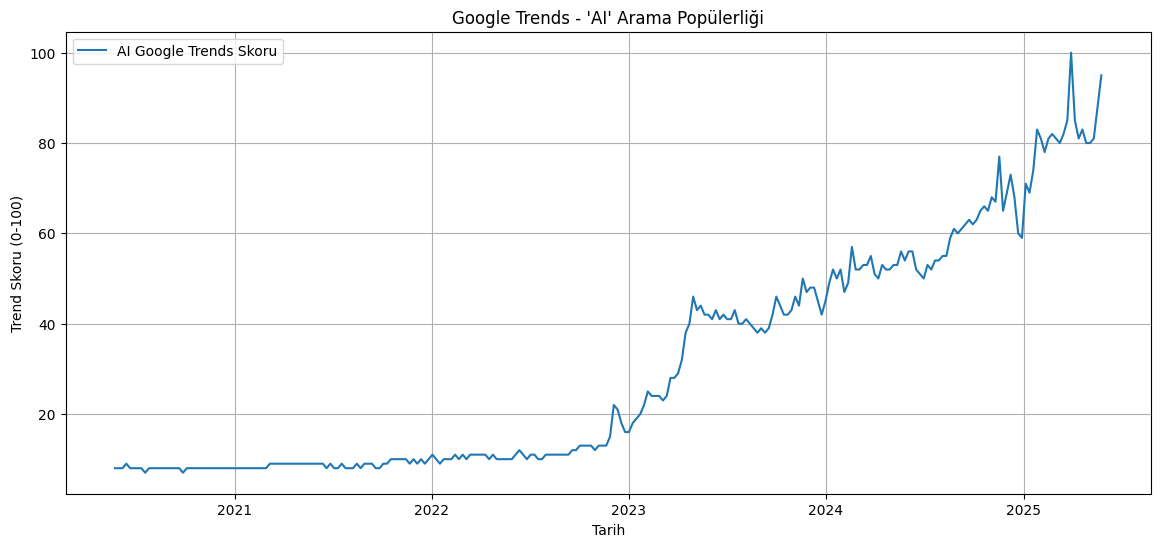

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df.index, df['AI'], label="AI Google Trends Skoru")
plt.title("Google Trends - 'AI' Arama Popülerliği")
plt.xlabel("Tarih")
plt.ylabel("Trend Skoru (0-100)")
plt.legend()
plt.grid()
plt.show()


In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['AI']])
# Veriyi Ölçekle (0-1 aralığına)

In [12]:
# Time Series Verisi Oluştur (X, y)
def create_dataset(data, time_step=20):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

time_step = 20
X, y = create_dataset(scaled_data, time_step)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Modeli oluştur
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(100))
model.add(Dense(1))

# Derle
model.compile(optimizer='adam', loss='mean_squared_error')

# Eğit
model.fit(X, y, epochs=30, batch_size=16, verbose=1)


Epoch 1/30


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0493
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016    
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017    
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017
Epoch 11/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
Epoch 12/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023
Epoch 13/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032
Epoch 14/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
Epoch 15/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
Epoch 1

In [15]:
# Tahmin yap
predicted = model.predict(X)

# Geri ölçekle
predicted_values = scaler.inverse_transform(predicted)
true_values = scaler.inverse_transform(y.reshape(-1, 1))
# Tahmin Yap ve Geri Ölçekle

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


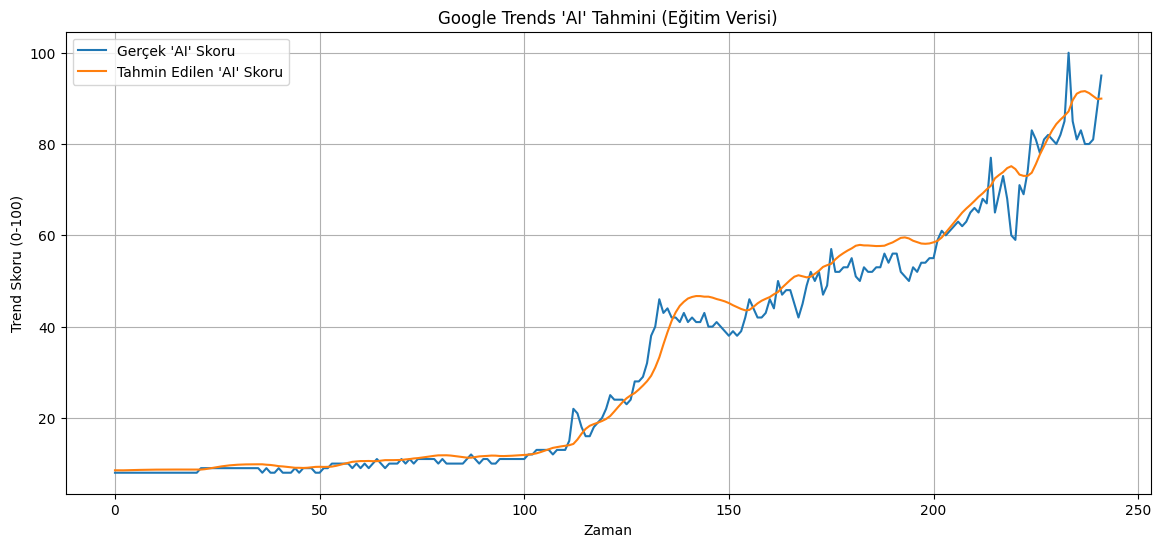

In [16]:
 # Gerçek vs Tahmin Görselleştirme

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(true_values, label="Gerçek 'AI' Skoru")
plt.plot(predicted_values, label="Tahmin Edilen 'AI' Skoru")
plt.title("Google Trends 'AI' Tahmini (Eğitim Verisi)")
plt.xlabel("Zaman")
plt.ylabel("Trend Skoru (0-100)")
plt.legend()
plt.grid()
plt.show()


In [17]:
# Son 20 haftalık veriyi al
last_sequence = scaled_data[-time_step:].reshape(1, time_step, 1)

future_predictions = []

for _ in range(20):  # 20 haftalık tahmin
    next_value = model.predict(last_sequence)[0][0]
    future_predictions.append(next_value)
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_value]]], axis=1)

# Geri ölçekle
future_values = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


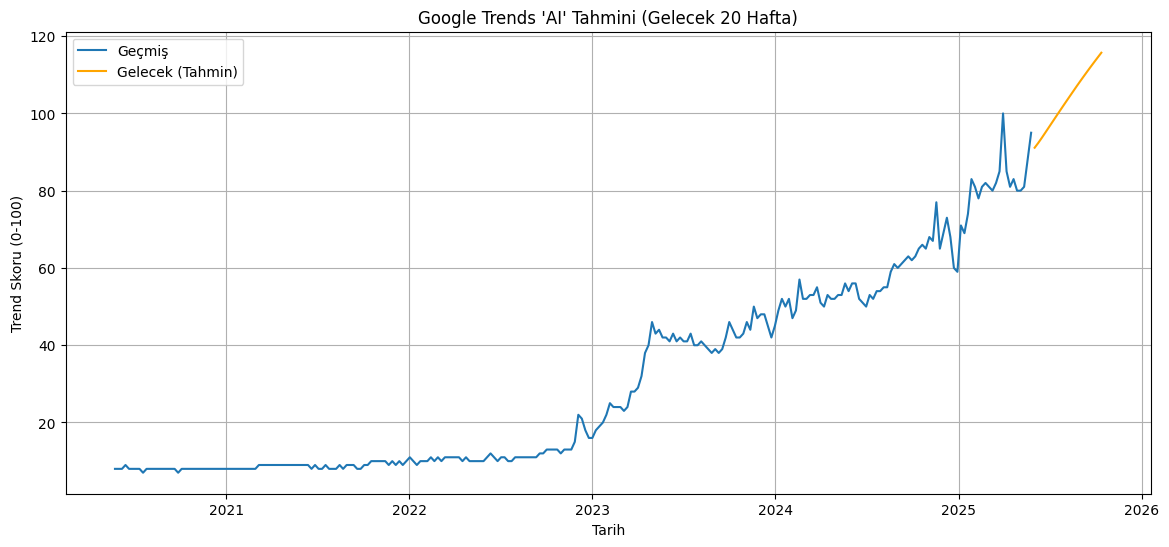

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Gelecek tarih aralığı
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(weeks=1), periods=20, freq='W')

# Grafik
plt.figure(figsize=(14,6))
plt.plot(df.index, df['AI'], label="Geçmiş")
plt.plot(future_dates, future_values, label="Gelecek (Tahmin)", color='orange')
plt.title("Google Trends 'AI' Tahmini (Gelecek 20 Hafta)")
plt.xlabel("Tarih")
plt.ylabel("Trend Skoru (0-100)")
plt.legend()
plt.grid()
plt.show()
